In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("../")
import os

import logging
from src.utils import logging_utils
from src.utils import env_utils
from src import functional

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}")
logger.info(f"{transformers.__version__=}")

/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2024-06-19 12:43:10 __main__ INFO     torch.__version__='2.3.1', torch.version.cuda='12.1'
2024-06-19 12:43:10 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=1, torch.cuda.get_device_name()='NVIDIA RTX A6000'
2024-06-19 12:43:10 __main__ INFO     transformers.__version__='4.41.2'


In [4]:
from nnsight import LanguageModel
from src.models import ModelandTokenizer

mt = ModelandTokenizer(
    model_key="meta-llama/Meta-Llama-3-8B",
    torch_dtype=torch.float16,
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


2024-06-19 12:43:11 accelerate.utils.modeling INFO     We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards: 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]

2024-06-19 12:43:15 src.models INFO     loaded model </home/local_arnab/Codes/saved_model_weights/meta-llama/Meta-Llama-3-8B> | size: 15316.516 MB | dtype: torch.float16 | device: cuda:0


In [5]:
from src.trace import trace_important_states
from src.trace import InContextQuery

clean_query = InContextQuery(
    subject="The Space Needle",
    cf_description="the capital of Japan",
    answer = "Tokyo",
)
# clean_query.set_template("<subj> is located in the city of")

corrput_query = InContextQuery(
    subject="Colosseum",
    cf_description="the capital of United Kingdom",
    answer = "London",
)
# corrput_query.set_template("<subj> is located in the city of")

print(clean_query.query)
print(corrput_query.query)

Assume an alternative universe where The Space Needle is in the capital of Japan. In that universe, The Space Needle is located in the city of
Assume an alternative universe where Colosseum is in the capital of United Kingdom. In that universe, Colosseum is located in the city of


In [6]:
indirect_effects = trace_important_states(
    mt=mt, 
    clean_query=clean_query,
    corrupt_query=corrput_query,
    kind="residual",
    normalize=True
)

2024-06-19 12:43:15 src.trace DEBUG    clean_subj_range=(21, 24) | corrupt_subj_range=(23, 27)
2024-06-19 12:43:15 src.trace DEBUG    setting subj_end=28
idx=0 =>  [1] <|begin_of_text|> || [1] <|begin_of_text|>
idx=1 =>  [1] Ass || [1] Ass
idx=2 =>  [1] ume || [1] ume
idx=3 =>  [1]  an || [1]  an
idx=4 =>  [1]  alternative || [1]  alternative
idx=5 =>  [1]  universe || [1]  universe
idx=6 =>  [1]  where || [1]  where
idx=7 =>  [1]  The || [1]  Col
idx=8 =>  [1]  Space || [1] os
idx=9 =>  [1]  Needle || [1] se
idx=10 =>  [1]  is || [1] um
idx=11 =>  [1]  in || [1]  is
idx=12 =>  [1]  the || [1]  in
idx=13 =>  [1]  capital || [1]  the
idx=14 =>  [1]  of || [1]  capital
idx=15 =>  [1]  Japan || [1]  of
idx=16 =>  [1] . || [1]  United
idx=17 =>  [1]  In || [1]  Kingdom
idx=18 =>  [1]  that || [1] .
idx=19 =>  [1]  universe || [1]  In
idx=20 =>  [1] , || [1]  that
idx=21 =>  [0] <|end_of_text|> || [1]  universe
idx=22 =>  [0] <|end_of_text|> || [1] ,
idx=23 =>  [0] <|end_of_text|> || [0] <|

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


2024-06-19 12:43:16 src.trace DEBUG    answer=PredictedToken(token=' Tokyo', prob=0.503361165523529, token_id=tensor(27286, device='cuda:0'))
2024-06-19 12:43:16 src.trace DEBUG    corrupt_answer=PredictedToken(token=' London', prob=0.6710155010223389, token_id=tensor(7295, device='cuda:0'))
2024-06-19 12:43:16 src.trace DEBUG    track_ans=[(166, PredictedToken(token=' Tokyo', prob=0.00022334889217745513, token_id=27286))]
2024-06-19 12:43:16 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 320/320 [00:11<00:00, 29.06it/s]


In [7]:
indirect_effects.answer

PredictedToken(token=' Tokyo', prob=0.503361165523529, token_id=tensor(27286, device='cuda:0'))

In [8]:
indirect_effects.answer.token_id

tensor(27286, device='cuda:0')

2024-06-19 12:43:28 matplotlib DEBUG    matplotlib data path: /home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/matplotlib/mpl-data
2024-06-19 12:43:28 matplotlib DEBUG    CONFIGDIR=/home/local_arnab/.config/matplotlib
2024-06-19 12:43:28 matplotlib DEBUG    interactive is False
2024-06-19 12:43:28 matplotlib DEBUG    platform is linux
2024-06-19 12:43:28 matplotlib DEBUG    CACHEDIR=/home/local_arnab/.cache/matplotlib
2024-06-19 12:43:28 matplotlib.font_manager DEBUG    Using fontManager instance from /home/local_arnab/.cache/matplotlib/fontlist-v330.json
2024-06-19 12:43:28 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-06-19 12:43:28 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-06-19 12:43:28 matplotlib.font_manager DEBUG    findfont: Matching Times New Roman:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2024-06-19 12:43

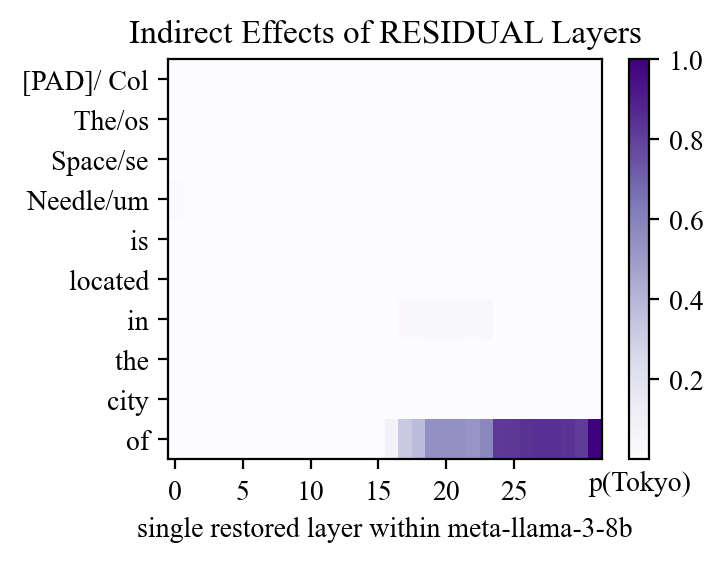

In [9]:
from src.plotting import plot_trace_heatmap

plot_trace_heatmap(indirect_effects, model_name=mt.name.lower().split("/")[-1])

In [10]:
indirect_effects_mlp = trace_important_states(
    mt=mt, 
    clean_query=clean_query,
    corrupt_query=corrput_query,
    kind="mlp",
    normalize=True,
    window_size=10
)

2024-06-19 12:43:28 src.trace DEBUG    clean_subj_range=(21, 24) | corrupt_subj_range=(23, 27)
2024-06-19 12:43:28 src.trace DEBUG    setting subj_end=28
idx=0 =>  [1] <|begin_of_text|> || [1] <|begin_of_text|>
idx=1 =>  [1] Ass || [1] Ass
idx=2 =>  [1] ume || [1] ume
idx=3 =>  [1]  an || [1]  an
idx=4 =>  [1]  alternative || [1]  alternative
idx=5 =>  [1]  universe || [1]  universe
idx=6 =>  [1]  where || [1]  where
idx=7 =>  [1]  The || [1]  Col
idx=8 =>  [1]  Space || [1] os
idx=9 =>  [1]  Needle || [1] se
idx=10 =>  [1]  is || [1] um
idx=11 =>  [1]  in || [1]  is
idx=12 =>  [1]  the || [1]  in
idx=13 =>  [1]  capital || [1]  the
idx=14 =>  [1]  of || [1]  capital
idx=15 =>  [1]  Japan || [1]  of
idx=16 =>  [1] . || [1]  United
idx=17 =>  [1]  In || [1]  Kingdom
idx=18 =>  [1]  that || [1] .
idx=19 =>  [1]  universe || [1]  In
idx=20 =>  [1] , || [1]  that
idx=21 =>  [0] <|end_of_text|> || [1]  universe
idx=22 =>  [0] <|end_of_text|> || [1] ,
idx=23 =>  [0] <|end_of_text|> || [0] <|

2024-06-19 12:43:29 src.trace DEBUG    answer=PredictedToken(token=' Tokyo', prob=0.503361165523529, token_id=tensor(27286, device='cuda:0'))
2024-06-19 12:43:29 src.trace DEBUG    corrupt_answer=PredictedToken(token=' London', prob=0.6710155010223389, token_id=tensor(7295, device='cuda:0'))
2024-06-19 12:43:29 src.trace DEBUG    track_ans=[(166, PredictedToken(token=' Tokyo', prob=0.00022334889217745513, token_id=27286))]
2024-06-19 12:43:29 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 320/320 [00:13<00:00, 23.57it/s]


2024-06-19 12:43:43 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f70352d2dd0>
2024-06-19 12:43:43 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-06-19 12:43:43 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-06-19 12:43:43 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-06-19 12:43:43 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


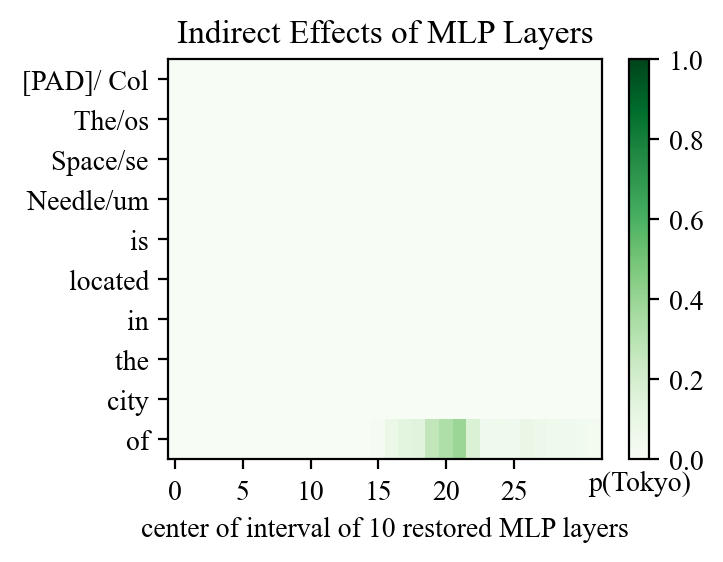

In [11]:
plot_trace_heatmap(indirect_effects_mlp, model_name=mt.name.lower().split("/")[-1], scale_range=(0, 1))

In [12]:
indirect_effects_attn = trace_important_states(
    mt=mt, 
    clean_query=clean_query,
    corrupt_query=corrput_query,
    kind="attention",
    normalize=True,
    window_size=10
)

2024-06-19 12:43:43 src.trace DEBUG    clean_subj_range=(21, 24) | corrupt_subj_range=(23, 27)
2024-06-19 12:43:43 src.trace DEBUG    setting subj_end=28
idx=0 =>  [1] <|begin_of_text|> || [1] <|begin_of_text|>
idx=1 =>  [1] Ass || [1] Ass
idx=2 =>  [1] ume || [1] ume
idx=3 =>  [1]  an || [1]  an
idx=4 =>  [1]  alternative || [1]  alternative
idx=5 =>  [1]  universe || [1]  universe
idx=6 =>  [1]  where || [1]  where
idx=7 =>  [1]  The || [1]  Col
idx=8 =>  [1]  Space || [1] os
idx=9 =>  [1]  Needle || [1] se
idx=10 =>  [1]  is || [1] um
idx=11 =>  [1]  in || [1]  is
idx=12 =>  [1]  the || [1]  in
idx=13 =>  [1]  capital || [1]  the
idx=14 =>  [1]  of || [1]  capital
idx=15 =>  [1]  Japan || [1]  of
idx=16 =>  [1] . || [1]  United
idx=17 =>  [1]  In || [1]  Kingdom
idx=18 =>  [1]  that || [1] .
idx=19 =>  [1]  universe || [1]  In
idx=20 =>  [1] , || [1]  that
idx=21 =>  [0] <|end_of_text|> || [1]  universe
idx=22 =>  [0] <|end_of_text|> || [1] ,
idx=23 =>  [0] <|end_of_text|> || [0] <|

100%|██████████| 320/320 [00:14<00:00, 21.43it/s]


2024-06-19 12:43:59 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f70354f94d0>
2024-06-19 12:43:59 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-06-19 12:43:59 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-06-19 12:43:59 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-06-19 12:43:59 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


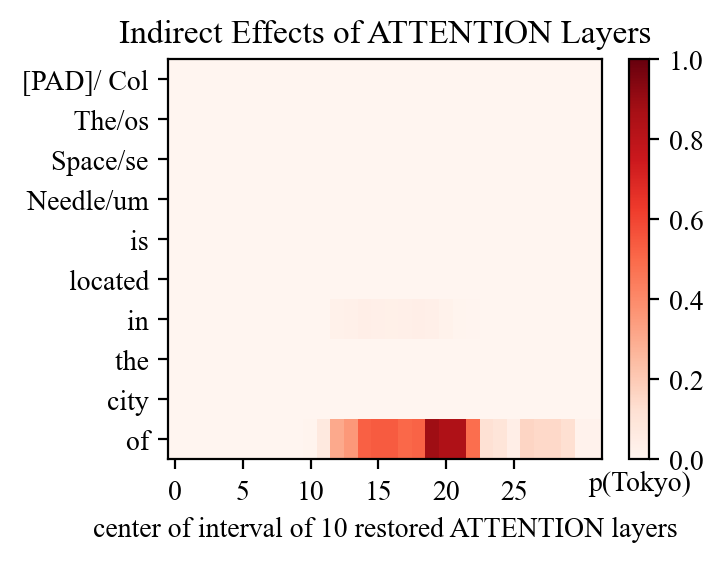

In [13]:
plot_trace_heatmap(indirect_effects_attn, model_name=mt.name.lower().split("/")[-1], scale_range=(0, 1))

In [14]:
from src.functional import get_module_nnsight, untuple
from src.models import prepare_input

dummy_prompt = [
    "The Space Needle is located in the city of",
    "Eiffel Tower"
]

# dummy_prompt = "Eiffel Tower"

inputs = prepare_input(
    tokenizer = mt, 
    prompts = dummy_prompt
)

# layer_name = mt.mlp_module_name_format.format(12)
layer_name = mt.layer_name_format.format(12)
# layer_name = mt.attn_module_name_format.format(12)

with mt.trace(inputs, scan = True, validate = True):
    module = get_module_nnsight(mt, layer_name)
    h = module.output.save()
    
print(len(h))
print(isinstance(h, torch.Tensor))
h.shape

2
False


(torch.Size([2, 10, 4096]), DynamicCache())

In [15]:
# from src.functional import get_all_module_states

# states = get_all_module_states(
#     mt=mt, 
#     input=inputs,
#     kind="attention",
# )

In [16]:
import baukit

with baukit.Trace(
    module=mt._model,
    layer=layer_name,
) as tr:
    output = mt._model(**inputs)

untuple(tr.output).shape

torch.Size([2, 10, 4096])

In [17]:
h.shape, untuple(tr.output).shape

((torch.Size([2, 10, 4096]), DynamicCache()), torch.Size([2, 10, 4096]))

In [18]:
from src.trace import patched_run

zero = torch.zeros(mt.n_embd, device=mt.device)

logits = patched_run(
    mt=mt, 
    inputs=inputs,
    states={
        (layer_name, 2): zero
    },
    kind="attention"
)